# NER Transformer Notebook Training

This is a notebook detailing the training of a transformer NER model using HuggingFace transformers.

## 1. Installs and Imports

In [ ]:
!pip install datasets transformers seqeval

     |████████████████████████████████| 298 kB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 29.1 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 1.1 MB 36.7 MB/s 
     |████████████████████████████████| 132 kB 18.9 MB/s 
     |████████████████████████████████| 61 kB 469 kB/s 
     |████████████████████████████████| 243 kB 41.4 MB/s 
     |████████████████████████████████| 895 kB 36.0 MB/s 
     |████████████████████████████████| 3.3 MB 46.7 MB/s 
     |████████████████████████████████| 596 kB 35.9 MB/s 
     |████████████████████████████████| 192 kB 37.7 MB/s 
     |████████████████████████████████| 271 kB 11.0 MB/s 
     |████████████████████████████████| 160 kB 32.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=927cac36bc2d007668a18c2439af40c19134042ff337c300c6b3ea81b341cfb2
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72

In [ ]:
import os
import random
import transformers
import pandas as pd
import pandas as pd
import numpy as np
from datetime import date
from google.colab import drive
from seqeval.metrics import accuracy_score
from IPython.display import display, HTML
from collections import defaultdict, Counter, OrderedDict
from datasets import load_dataset, load_metric, load_from_disk, ClassLabel, Sequence
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification

#inference
import torch
from transformers import pipeline

print(transformers.__version__)

4.13.0


In [ ]:
system = "COLAB" #["AWS", "COLAB"]

In [ ]:
if system=="AWS":
    fs = s3fs.S3FileSystem()    
    s3_bucket = "govuk-data-infrastructure-integration"
    DATA_DIR = f's3://{s3_bucket}/model-data/govner-data'
    for f in fs.ls(DATA_DIR):
        print(f)
    #Manage interactions with the Amazon SageMaker APIs and any other AWS services needed.
    # sagemaker session bucket -> used for uploading data, models and logs
    # sagemaker will automatically create this bucket if it not exists
    sess = sagemaker.Session() 
    sagemaker_session_bucket= s3_bucket
    if sagemaker_session_bucket is None and sess is not None:
        # set to default bucket if a bucket name is not given
        sagemaker_session_bucket = sess.default_bucket()
        
    role = sagemaker.get_execution_role()
    sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

    print(f"sagemaker role arn: {role}")
    print(f"sagemaker bucket: {sess.default_bucket()}")
    print(f"sagemaker session region: {sess.boto_region_name}")
elif system=="COLAB":
    drive.mount("/content/gdrive")
    DATA_DIR = os.path.join("/content/gdrive/Shared drives/", "GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Data")
    MODEL_DIR = os.path.join("/content/gdrive/Shared drives/", "GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models")
    RESULTS_DIR = os.path.join("/content/gdrive/Shared drives/", "GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/Metrics")

Mounted at /content/gdrive


In [ ]:
print("Data Folder: {}".format(DATA_DIR))
print(os.listdir(DATA_DIR)[:3])
print("Model Folder: {}".format(MODEL_DIR))
print(os.listdir(MODEL_DIR)[:3])

Data Folder: /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Data
['label_map_09062020_more_ents.json', 'label_map_12062020_more_ents.json', 'line_by_line_NER_data_sampled_09062020_more_ents.csv']
Model Folder: /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models
['distilbert-base-uncased-finetuned-ner-conll2003', 'distilbert-base-uncased-finetuned-ner-govuk', 'distilbert-base-uncased-finetuned-ner-govuk-SAMPLED-08-12-2021']


## 2. Load Data

Define some variables that will be useful.

In [ ]:
task = "ner"
dataset_name = "govuk"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [ ]:
dataset_type = "FULL" #"FULL"

In [ ]:
if dataset_type == "SAMPLED":
  hf_data = 'samp_hf_govuk_data'
  hf_data_path = f'{DATA_DIR}/{hf_data}'
  print("Data path: {}".format(hf_data_path))
elif dataset_type == "FULL":
  hf_data = 'hf_govuk_data'
  hf_data_path = f'{DATA_DIR}/{hf_data}'
  print("Data path: {}".format(hf_data_path))

Data path: /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Data/hf_govuk_data


Load the dataset that has been saved to disk in a HuggingFace DatasetDict (Apache Arrow).

In [ ]:
datasets = load_from_disk(hf_data_path)

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['new_label_list_id', 'text_token'],
        num_rows: 295133
    })
    test: Dataset({
        features: ['new_label_list_id', 'text_token'],
        num_rows: 52083
    })
})

Inspect an element

In [ ]:
datasets["train"][5]

{'new_label_list_id': [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'text_token': ['There',
  'is',
  'no',
  'minimum',
  'time',
  'commitment',
  '-',
  'you',
  'choose',
  'how',
  'much',
  'you',
  'do',
  '.']}

The labels are already coded as integer ids to be easily usable by our model, but the correspondence with the actual categories is stored in the features of the dataset:

In [ ]:
label_map = {"O": 0,
             "I-CONTACT": 1,
             "I-DATE": 2,
             "I-EVENT": 3,
             "I-FINANCE": 4,
             "I-FORM": 5,
             "I-LOC": 6,
             "I-MISC": 7,
             "I-MONEY": 8,
             "I-ORG": 9,
             "I-PER": 10,
             "I-SCHEME": 11,
             "I-STATE": 12}

In [ ]:
labels = ["O","I-CONTACT","I-DATE","I-EVENT","I-FINANCE","I-FORM","I-LOC", "I-MISC", "I-MONEY","I-ORG","I-PER","I-SCHEME","I-STATE"]

In [ ]:
datasets["train"].features[f"new_label_list_id"] = Sequence(feature=ClassLabel(num_classes=13, names=labels, names_file=None, id=None), length=-1, id=None)
datasets["test"].features[f"new_label_list_id"] = Sequence(feature=ClassLabel(num_classes=13, names=labels, names_file=None, id=None), length=-1, id=None)

In [ ]:
label_list = datasets["train"].features[f"new_label_list_id"].feature.names
label_list

['O',
 'I-CONTACT',
 'I-DATE',
 'I-EVENT',
 'I-FINANCE',
 'I-FORM',
 'I-LOC',
 'I-MISC',
 'I-MONEY',
 'I-ORG',
 'I-PER',
 'I-SCHEME',
 'I-STATE']

Show some random examples from the dataset in HTML format - this makes it easier to read than from the json.

In [ ]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

,new_label_list_id,text_token
0,"[O, I-PER, O, O, O, I-EVENT, O, O, I-FINANCE, I-FORM, O]","[When, individuals, will, get, the, decision, on, a, PIP, claim, .]"
1,"[O, O, O, O, O, O, O, I-ORG, O, O, I-LOC, O, O, I-LOC, I-LOC, O, O, I-LOC, O, O, O, O, O, O, I-ORG, O]","[The, GREAT, Tech, Awards, encourage, high-growth, technology, companies, in, the, US, to, select, the, UK, as, a, place, to, set, up, and, grow, their, businesses, .]"
2,"[O, O, O, O, O, O, O, I-ORG, O, O, O, O, O, O, O, O, O]","[Our, core, purpose, is, to, help, the, government, govern, well, ,, within, the, rule, of, law, .]"
3,"[O, I-ORG, O, O, O, O, O, O, O, O, O, O, O, O, I-SCHEME, O, O, O, O, O, O, O, O, O, O, O, O, O]","[The, MOD, takes, conservation, very, seriously, and, we, are, committed, to, completing, a, replanting, scheme, to, replace, felled, ash, trees, with, a, range, of, native, species, trees, .]"
4,"[O, O, I-STATE, O, I-DATE, I-DATE, I-DATE, O, I-DATE, I-DATE, I-DATE, O]","[It, is, valid, from, 1, May, 2018, to, 30, April, 2020, .]"
5,"[O, O, O, I-PER, O, O, O, I-PER, O, I-PER, O, I-PER, O]","[Notice, to, :, owners, ,, masters, ,, skippers, ,, officers, ,, crews, .]"
6,"[O, O, O, O, O, I-FORM, O, O, O, O]","[You, can, not, use, an, EHIC, for, planned, treatment, .]"
7,"[I-STATE, O, O, O, O, O, O, O, O, O, O, I-LOC, O, O, O, O]","[Iraqi, and, U.S., forces, launched, a, massive, sweep, for, militants, in, Baghdad, two, weeks, ago, .]"
8,"[I-ORG, O, O, O, O, O, O, I-FORM, O, O, O, O]","[ESFA, :, round, 2, supplementary, data, collection, guidance, :, version, 1, .]"
9,"[O, O, O, O, O, O, O, I-PER, O, I-FINANCE, O, O, O, I-DATE, I-DATE, I-DATE, O]","[This, resulted, in, the, suspension, of, a, majority, of, asset, freeze, targets, on, 1, November, 2015, .]"


## 3. Tokenise the Data

Download tokeniser that will be used to tokenise the data.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

The assert keyword lets you test if a condition in your code returns True, if not, the program will raise an AssertionError.

In [ ]:
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

How does the tokeniser work?

In [ ]:
#observe how the tokeniser works on a string
tokenizer("Hello, this is one sentence!")

{'input_ids': [101, 7592, 1010, 2023, 2003, 2028, 6251, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
#observe how the tokeniser works on a list of tokens
tokenizer(["Hello", ",", "this", "is", "one", "sentence", "split", "into", "words", "."], is_split_into_words=True)

{'input_ids': [101, 7592, 1010, 2023, 2003, 2028, 6251, 3975, 2046, 2616, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Try this out on example, tokens 4 from training set.

In [ ]:
example = datasets["train"][5]
print(example["text_token"])

['There', 'is', 'no', 'minimum', 'time', 'commitment', '-', 'you', 'choose', 'how', 'much', 'you', 'do', '.']


In [ ]:
tokenized_input = tokenizer(example["text_token"], is_split_into_words=True)
print(tokenized_input)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

{'input_ids': [101, 2045, 2003, 2053, 6263, 2051, 8426, 1011, 2017, 5454, 2129, 2172, 2017, 2079, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'there', 'is', 'no', 'minimum', 'time', 'commitment', '-', 'you', 'choose', 'how', 'much', 'you', 'do', '.', '[SEP]']


Print the number of token labels in the data, and the length of the tokenised input. They are different, because special tokens are added to the start and end of a list when tokenised.

In [ ]:
len(example[f"new_label_list_id"]), len(tokenized_input["input_ids"])

(14, 16)

If we look into these examples, we can see they are added to the start and end.

In [ ]:
print(tokenized_input.word_ids())

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, None]


We can align these labels, by adding '-100' where there are None.

In [ ]:
word_ids = tokenized_input.word_ids()
print(word_ids)
aligned_labels = [-100 if i is None else example[f"new_label_list_id"][i] for i in word_ids]
print(aligned_labels)
print(len(aligned_labels), len(tokenized_input["input_ids"]))

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, None]
[-100, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]
16 16


We now need to tokenise each example and align the labels.


In [ ]:
label_all_tokens = True

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["text_token"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"new_label_list_id"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i) # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100. Special tokens have a word id that is None. We set the label to -100 so they are automatically ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx: # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:                   # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

Now we can tokenise and align training examples in the datasets.

In [ ]:
tokenize_and_align_labels(datasets['train'][:5])

{'input_ids': [[101, 2000, 2113, 2062, 2006, 14952, 1999, 8341, 1010, 3942, 1996, 3757, 1997, 5446, 2880, 9445, 1012, 102], [101, 2045, 2024, 3155, 2531, 16683, 2015, 2802, 1996, 2866, 1010, 5094, 2058, 13509, 2402, 2111, 2169, 2095, 1012, 102], [101, 2004, 1996, 4254, 1997, 1996, 3663, 19852, 2015, 1996, 2951, 3074, 23839, 2097, 2022, 2104, 3319, 1012, 102], [101, 2044, 2017, 1521, 2310, 5068, 1010, 2017, 2442, 2425, 1054, 4502, 1521, 1055, 6240, 4087, 11683, 2136, 1010, 2306, 2654, 2420, 1010, 2065, 2151, 1997, 1996, 2206, 4751, 2689, 1012, 102], [101, 5279, 1005, 1055, 3356, 2160, 1997, 3323, 4465, 4844, 1037, 10037, 2013, 2343, 7570, 2015, 3490, 14163, 20709, 2243, 2005, 1037, 2048, 1011, 2095, 5331, 2000, 1996, 2744, 1997, 2334, 10784, 1010, 2087, 1997, 2029, 2024, 6817, 2011, 2372, 1997, 1996, 6996, 2120, 3537, 2283, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1,

In [ ]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Loading cached processed dataset at /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Data/hf_govuk_data/train/cache-981f180f9c19802f.arrow
Loading cached processed dataset at /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Data/hf_govuk_data/test/cache-35f5fd639dc4cdf9.arrow


## 3. Metrics

We can use common metrics, such as those used by NER evaluation strategies - however, our training data is not organised in any of the IOB1, IOB2, IOE1, IOE2, IOBES or IO formats.

For this reason, we may need to use custom metrics. But we can try with both and assess outputs.

### 3A. 'seqeval' metrics

In [ ]:
metric = load_metric("seqeval")

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

In [ ]:
label_list

['O',
 'I-CONTACT',
 'I-DATE',
 'I-EVENT',
 'I-FINANCE',
 'I-FORM',
 'I-LOC',
 'I-MISC',
 'I-MONEY',
 'I-ORG',
 'I-PER',
 'I-SCHEME',
 'I-STATE']

In [ ]:
labels = [label_list[i] for i in example[f"new_label_list_id"]]
print(labels)
metric.compute(predictions=[labels], references=[labels])

['O', 'O', 'O', 'O', 'I-EVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


{'EVENT': {'f1': 1.0, 'number': 1, 'precision': 1.0, 'recall': 1.0},
 'overall_accuracy': 1.0,
 'overall_f1': 1.0,
 'overall_precision': 1.0,
 'overall_recall': 1.0}

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
                        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
                        for prediction, label in zip(predictions, labels)
                        ]
    true_labels = [
                  [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
                  for prediction, label in zip(predictions, labels)
                  ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

## 4. Modelling

First, instantiate a model that will be used, **make sure it is the same as the tokeniser you are using!** Use the number of labels that are in your label list - this ensures there will be an output class for each token.

In [ ]:
id2label = {str(i): label for i, label in enumerate(label_list)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "O",
    "1": "I-CONTACT",
    "10": "I-PER",
    "11": "I-SCHEME",
    "12": "I-STATE",
    "2": "I-DATE",
    "3": "I-EVENT",
    "4": "I-FINANCE",
    "5": "I-FORM",
    "6": "I-LOC",
    "7": "I-MISC",
    "8": "I-MONEY",
    "9": "I-ORG"
  },
  "initializer_range": 0.02,
  "label2id": {
    "I-CONTACT": "1",
    "I-DATE": "2",
    "I-EVENT": "3",
    "I-FINANCE": "4",
    "I-FORM": "5",
    "I-LOC": "6",
    "I-MISC": "7",
    "I-MONEY": "8",
    

Define the training arguments that will dictate how the model will train.

In [ ]:
model_name = model_checkpoint.split("/")[-1]
tod_date = date.today().strftime("%d-%m-%Y")
full_model_name = f"{model_name}-finetuned-{task}-{dataset_name}-{dataset_type}-{tod_date}"
# print(full_model_name)
# print(MODEL_DIR)
OUTPUT_PATH = f"{MODEL_DIR}/{full_model_name}"
print(OUTPUT_PATH)

args = TrainingArguments(
    output_dir=OUTPUT_PATH,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=4,
    weight_decay=0.01,
    push_to_hub=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


/content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021


The *Data Collator* in the trainer, automatically pads the model inputs in a batch to the length of the longest example. This bypasses the need to set a global maximum sequence length, and in practice leads to faster training since we perform fewer redundant computations on the padded tokens and attention masks.

For token classification tasks, there is a dedicated *DataCollatorForTokenClassification* which expects a list of dicts, where each dict represents a single example in the dataset.



In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: new_label_list_id, text_token.
***** Running training *****
  Num examples = 295133
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 73784


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.065500,0.062022,0.903813,0.946603,0.924713,0.979381
2,0.050500,0.050030,0.924614,0.947879,0.936102,0.982546
3,0.039800,0.045850,0.930562,0.954038,0.942154,0.984148
4,0.032300,0.046112,0.933533,0.954117,0.943713,0.984500


Saving model checkpoint to /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/checkpoint-500
Configuration saved in /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/checkpoint-500/config.json
Model weights saved in /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-

TrainOutput(global_step=73784, training_loss=0.057687467961588974, metrics={'train_runtime': 13215.1082, 'train_samples_per_second': 89.332, 'train_steps_per_second': 5.583, 'total_flos': 1.123029929954304e+16, 'train_loss': 0.057687467961588974, 'epoch': 4.0})

In [ ]:
tokenizer.save_pretrained(OUTPUT_PATH)

tokenizer config file saved in /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/tokenizer_config.json
Special tokens file saved in /content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/special_tokens_map.json


('/content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/tokenizer_config.json',
 '/content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/special_tokens_map.json',
 '/content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/vocab.txt',
 '/content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/added_tokens.json',
 '/content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/tokenizer.json')

## Get Classification Report Metrics

Use the evaluate method allows you to evaluate again on the evaluation dataset or on another dataset:


In [ ]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: new_label_list_id, text_token.
***** Running Evaluation *****
  Num examples = 52083
  Batch size = 16


{'epoch': 4.0,
 'eval_accuracy': 0.9844996486214141,
 'eval_f1': 0.9437128008877348,
 'eval_loss': 0.04611240327358246,
 'eval_precision': 0.9335329148559472,
 'eval_recall': 0.9541171516180399,
 'eval_runtime': 203.2741,
 'eval_samples_per_second': 256.221,
 'eval_steps_per_second': 16.018}

Get the precision/recall/f1 computed for each category now that training is done. Apply the same function as before on the result of the predict method.

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results_df = pd.DataFrame(results).T

NameError: ignored

In [ ]:
results_df

,precision,recall,f1,number
CONTACT,0.962903,0.973525,0.968185,12238.000000
DATE,0.910149,0.935827,0.922809,15879.000000
EVENT,0.950596,0.976259,0.963257,13816.000000
FINANCE,0.919373,0.940531,0.929831,14209.000000
FORM,0.942978,0.962791,0.952782,12470.000000
LOC,0.967475,0.970936,0.969203,20128.000000
MISC,0.925000,0.972718,0.948259,4032.000000
MONEY,0.919127,0.920308,0.919717,778.000000
ORG,0.945779,0.956555,0.951136,22557.000000
PER,0.895550,0.927513,0.911251,25301.000000


In [ ]:
print(RESULTS_DIR)

print(full_model_name)

excel_path = f"{RESULTS_DIR}/{full_model_name}.xlsx"

/content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/Metrics
distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021


In [ ]:
results_df.to_excel(excel_path, sheet_name=full_model_name)

/usr/local/lib/python3.7/dist-packages/openpyxl/workbook/child.py:102: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## Confusion Matrices

In [ ]:
for i in tokenized_datasets['test'][1]:
  print(i, len(tokenized_datasets['test'][1][i]), tokenized_datasets['test'][1][i])

attention_mask 37 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
input_ids 37 [101, 2065, 2017, 2024, 1010, 10373, 1996, 4044, 4034, 2000, 2156, 2065, 2017, 2064, 5993, 2609, 3563, 6214, 1024, 4372, 15549, 5134, 1030, 4044, 1011, 4034, 1012, 18079, 1012, 2866, 2478, 1996, 5845, 12699, 2015, 1012, 102]
labels 37 [-100, 0, 0, 0, 0, 1, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, -100]
new_label_list_id 26 [0, 0, 0, 0, 1, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 9, 0, 0, 0, 0, 0]
text_token 26 ['If', 'you', 'are', ',', 'email', 'the', 'Environment', 'Agency', 'to', 'see', 'if', 'you', 'can', 'agree', 'site', 'specific', 'circumstances', ':', 'enquiries', '@', 'environment-agency.gov.uk', 'Using', 'the', 'treated', 'washings', '.']


Load model in

In [ ]:
MODEL_DIR 
model_name = "distilbert-base-uncased"
task = "ner"
dataset_name = "govuk"
req_date = "13-12-2021"
dataset_type = 'FULL'
chkpoint = 'checkpoint-73500'

In [ ]:
TRAINED_MODEL_PATH = f"{MODEL_DIR}/{model_name}-finetuned-{task}-{dataset_name}-{dataset_type}-{req_date}/{chkpoint}"
TRAINED_MODEL_PATH

'/content/gdrive/Shared drives/GOV.UK teams/2020-2021/Data labs/content-metadata-2021/Models/distilbert-base-uncased-finetuned-ner-govuk-FULL-13-12-2021/checkpoint-73500'

In [ ]:
os.listdir(TRAINED_MODEL_PATH)

['config.json',
 'pytorch_model.bin',
 'tokenizer_config.json',
 'special_tokens_map.json',
 'vocab.txt',
 'tokenizer.json',
 'training_args.bin',
 'optimizer.pt',
 'scheduler.pt',
 'trainer_state.json',
 'rng_state.pth']

Load model and tokeniser

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(TRAINED_MODEL_PATH)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    TRAINED_MODEL_PATH, 
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
trainer = Trainer(
    model,
    #args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: text_token, new_label_list_id.
***** Running Evaluation *****
  Num examples = 52083
  Batch size = 8


{'eval_accuracy': 0.9844933337302694,
 'eval_f1': 0.9436730177842139,
 'eval_loss': 0.046071432530879974,
 'eval_precision': 0.933505450003541,
 'eval_recall': 0.9540645110347823,
 'eval_runtime': 243.6524,
 'eval_samples_per_second': 213.759,
 'eval_steps_per_second': 26.722}

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results_df = pd.DataFrame(results).T

The following columns in the test set  don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: text_token, new_label_list_id.
***** Running Prediction *****
  Num examples = 52083
  Batch size = 8


In [ ]:
labs = list(results.keys())[:12]
labs.append('O')
labs

['CONTACT',
 'DATE',
 'EVENT',
 'FINANCE',
 'FORM',
 'LOC',
 'MISC',
 'MONEY',
 'ORG',
 'PER',
 'SCHEME',
 'STATE',
 'O']

In [ ]:
results_df

,precision,recall,f1,number
CONTACT,0.962978,0.973443,0.968182,12238.000000
DATE,0.909909,0.935638,0.922594,15879.000000
EVENT,0.950529,0.976259,0.963222,13816.000000
FINANCE,0.919252,0.940601,0.929804,14209.000000
FORM,0.943057,0.962871,0.952861,12470.000000
LOC,0.967474,0.970886,0.969177,20128.000000
MISC,0.925000,0.972718,0.948259,4032.000000
MONEY,0.919127,0.920308,0.919717,778.000000
ORG,0.945816,0.956466,0.951111,22557.000000
PER,0.895538,0.927394,0.911188,25301.000000


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
true_labels_flat = [item for sublist in true_labels for item in sublist]
true_preds_flat = [item for sublist in true_predictions for item in sublist]

CM without 'O'

In [ ]:
confmat = confusion_matrix(y_true=true_labels_flat, y_pred=true_preds_flat)

confmat_2 = [i[:-1] for i in confmat[:-1]]
confmat_2 = np.array(confmat_2)
cmplot = ConfusionMatrixDisplay(confmat_2, display_labels=labs)

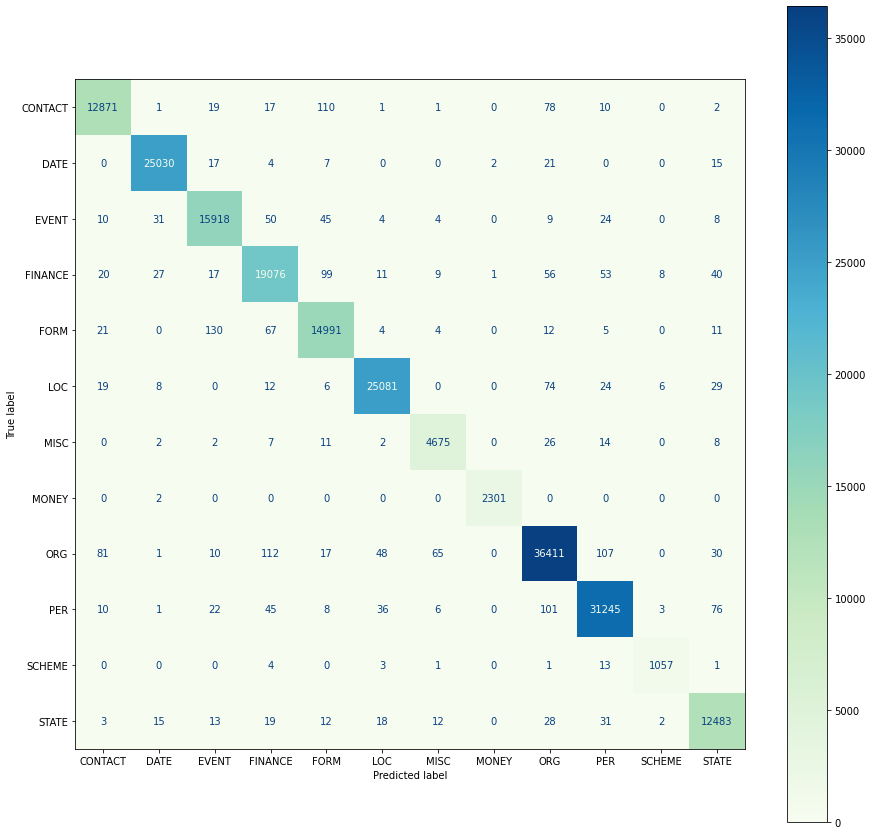

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
cmplot.plot(ax=ax, cmap='GnBu')

CM Without 'O'

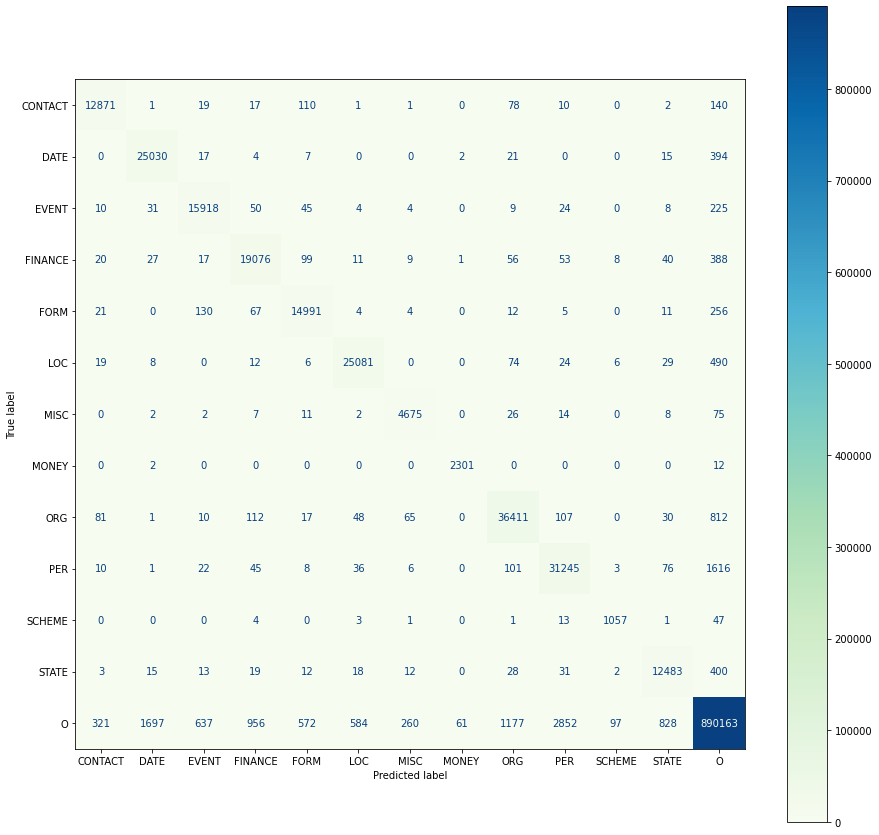

In [ ]:
confmat = confusion_matrix(y_true=true_labels_flat, y_pred=true_preds_flat)
# confmat_2 = np.array(confmat_2)
cmplot = ConfusionMatrixDisplay(confmat, display_labels=labs)
fig, ax = plt.subplots(figsize=(15,15))
cmplot.plot(ax=ax, cmap='GnBu')